# Лабораторная работа №3

## Описание и оценка датасета

### Описание датасета

В данной работе воспользуемся датасетом со статистикой игроков NBA с 2016 по 2019 год. 

Name (string) - Имя игрока.

POS (string) - Позиция игрока.


G (int) - Количество сыгранных матчей.

MP (float) - Среднее количество минут, проведенных на паркете за игру.


FG (float) - Среднее число результативных бросков за игру.

FGA (float) - Среднее число бросков за игру.

FG% (float) - Процент результативных бросков.


3P (float) - Среднее число результативных 3-очковых бросков за игру.

3PA (float) - Среднее число 3-очковых бросков за игру.

3P% (float) - Процент попаданий из-за 3-очковой дуги.


2P (float) - Среднее число результативных 2-очковых бросков за игру.

2PA (float) - Среднее число 2-очковых бросков за игру.

2P% (float) - Процент попаданий из 2-очковой зоны.


FTM (float) - Среднее число результативных штрафных бросков за игру.

FTA (float) - Среднее число штрафных бросков за игру.

FT% (float) - Процент попаданий штрафных бросков.


ORB (float) - Среднее число подборов в нападении за игру.

DRB (float) - Среднее число подборов в защите за игру.

TRB (float) - Среднее число подборов за игру.


AST (float) - Среднее число результативных передач за игру

STL (float) - Среднее число перехватов за игру.

BLK (float) - Среднее число блок-шотов за игру.

TOV (float) - Среднее число потерь за игру.

PTS (float) - Среднее число очков за игру




Датасет взят из: https://www.kaggle.com/datasets/abdurahmanmaarouf/nba-players-stats-2016-2017

Данные реальные.

### Метка классификации

В качестве целевой метки выступит атрибут POS, т.е. мы будем классифицировать игроков по игровым позициям, отталкиваясь от их статистики.

Позиции в датасете:

PG - разыгрывающий защитник

SG - атакующий защитник

SF - легкий форвард

PF - тяжелый форвард

C  - центровой

### Оценка датасета

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn

In [2]:
data = pd.read_csv("../datasets/nba.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    1953 non-null   object 
 1   POS     1953 non-null   object 
 2   G       1953 non-null   int64  
 3   MP      1953 non-null   float64
 4   FG      1953 non-null   float64
 5   FGA     1953 non-null   float64
 6   FG%     1941 non-null   float64
 7   3P      1953 non-null   float64
 8   3PA     1953 non-null   float64
 9   3P%     1795 non-null   float64
 10  2P      1953 non-null   float64
 11  2PA     1953 non-null   float64
 12  2P%     1915 non-null   float64
 13  eFG%    1941 non-null   float64
 14  FT      1953 non-null   float64
 15  FTA     1953 non-null   float64
 16  FT%     1828 non-null   float64
 17  ORB     1953 non-null   float64
 18  DRB     1953 non-null   float64
 19  TRB     1953 non-null   float64
 20  AST     1953 non-null   float64
 21  STL     1953 non-null   float64
 22  

Избавимся от записей с пустыми полями

In [3]:
data = data.dropna()

Посмотрим сколько уникальных меток существует в датасете

In [4]:
data['POS'].value_counts(normalize=True)

POS
SG    0.248389
PG    0.216755
PF    0.204452
SF    0.183363
C     0.147042
Name: proportion, dtype: float64

Видим, что классы, в принципе, сбалансированы.

## Классификация

In [5]:
# Отбираем атрибуты со статистикой
stat_columns = [col for col in data if col != 'POS' and col != 'Name']

X = data[stat_columns]
Y = data['POS']

Так как элементы атрибута POS - строки, конвертируем их. А также стандартизуем статистические данные

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

Поделим данные на тренировочные и тестовые

In [7]:
from sklearn.model_selection import train_test_split

X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, stratify=Y)

## kNN

Сперва найдем оптимальный параметр k для kNN при помощи GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# будем перебирать число соседей от 1 до 30
grid_params = {'n_neighbors': [i for i in range(1, 30+1)],
               'weights': ['uniform', 'distance'],
               'metric': ['minkowski', 'euclidean', 'manhattan']
              }

# ищем K
gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)

g_res = gs.fit(X_tr, Y_tr)

# лучшие параметры
k = g_res.best_params_['n_neighbors']
metric = g_res.best_params_['metric']
weights = g_res.best_params_['weights']

g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

Лучшие параметры для kNN приведены выше. Теперь же, пользуясь этими значениями, проведем kNN-классификацию.

In [9]:
knn = KNeighborsClassifier(n_neighbors=k, weights=weights).fit(X_tr, Y_tr)
# запускаем классификацию на тестовой выборке
predicted = knn.predict(X_t)

### Оценка качества классификации

Accuary оценка качества классификации:

In [10]:
right = 0
wrong = 0

for i, pos in enumerate(Y_t):
    if predicted[i] == pos:
        right += 1
    else:
        wrong += 1
        
accuracy = right / (right + wrong)
print(accuracy)

0.639344262295082


Precision, Recall, F1 оценки качества:

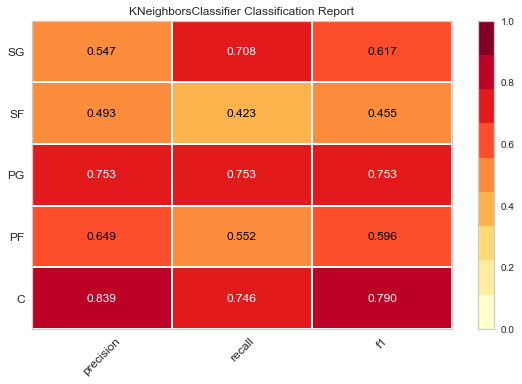

In [11]:
from yellowbrick.classifier import ClassificationReport

report = ClassificationReport(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

ROC оценка качества:

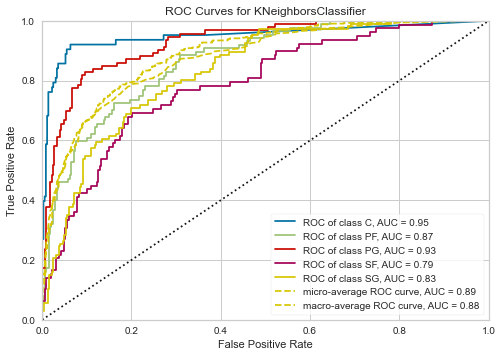

In [12]:
from yellowbrick.classifier import ROCAUC

report = ROCAUC(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

### Анализ классификации

## Дерево решений

Проведем классификацию

In [13]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_tr, Y_tr)

predicted = dtc.predict(X_t)

### Оценка качества классификации

Accuracy оценка качества классификации

In [14]:
right = 0
wrong = 0

for i, pos in enumerate(Y_t):
    if predicted[i] == pos:
        right += 1
    else:
        wrong += 1
        
accuracy = right / (right + wrong)
print(accuracy)

0.5620608899297423


Precision, Recall, F1 оценки качества:

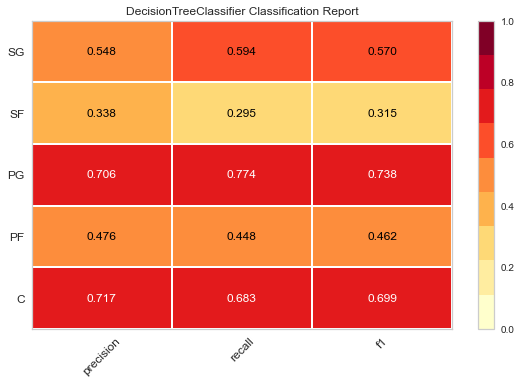

In [15]:
report = ClassificationReport(dtc, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

ROC оценка классификации

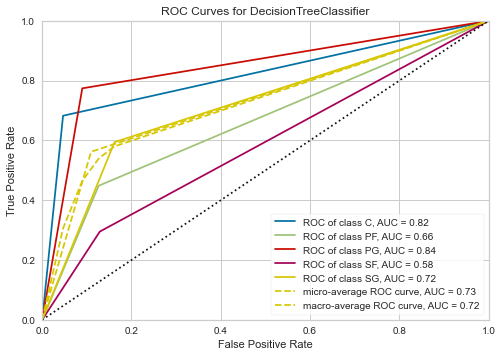

In [16]:
report = ROCAUC(dtc, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

### Анализ классификации